In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Pipelines: Evaluating batch prediction results from AutoML video classification model

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/lightweight_functions_component_io_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fnotebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/lightweight_functions_component_io_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/pipelines/lightweight_functions_component_io_kfp.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
     </a>
   </td>
</table>
<br/><br/><br/>

## Overview

This notebook demonstrates how to use the Vertex AI classification model evaluation component to evaluate an AutoML video classification model. Model evaluation helps you determine your model performance based on the evaluation metrics and improve the model if necessary. 

Learn more about [Vertex AI Model Evaluation](https://cloud.google.com/vertex-ai/docs/evaluation/introduction) and [Classification for video data](https://cloud.google.com/vertex-ai/docs/training-overview#classification_for_videos).

### Objective

In this tutorial, you learn how to train a Vertex AI AutoML Video classification model and learn how to evaluate it through a Vertex AI pipeline job using google_cloud_pipeline_components:

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Datasets
- Vertex AI Training(AutoML Video Classification) 
- Vertex AI Model Registry
- Vertex AI Pipelines
- Vertex AI Batch Predictions



The steps performed include:

- Create a Vertex AI Dataset.
- Train a Automl Video Classification model on the Vertex AI Dataset resource.
- Import the trained AutoML Vertex AI Model resource into the pipeline.
- Run a batch prediction job inside the pipeline.
- Evaluate the AutoML model using the classification evaluation component.
- Import the classification metrics to the AutoML Vertex AI Model resource.

### Dataset

The dataset used for this tutorial is the golf swing recognition portion of the [Human Motion dataset from MIT](http://cbcl.mit.edu/publications/ps/Kuehne_etal_iccv11.pdf). The version of the dataset you use in this tutorial is stored in a public Cloud Storage bucket. The trained model predicts the start frame where a golf swing begins.


### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and
[Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the
[Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Get started

Install Vertex AI SDK for Python and other required packages


In [1]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 google-cloud-pipeline-components \
                                 google-cloud-storage \
                                 matplotlib

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment)

In [4]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [5]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [6]:
! gsutil mb -l $LOCATION -p $PROJECT_ID $BUCKET_URI

Creating gs://automl-video-model-vertexai-service-project-unique/...
ServiceException: 409 A Cloud Storage bucket named 'automl-video-model-vertexai-service-project-unique' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Import libraries

In [7]:
import json

import google.cloud.aiplatform as aiplatform
import matplotlib.pyplot as plt
from google.cloud import aiplatform_v1, storage

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [8]:
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

### Location of training data

Now set the variable `IMPORT_FILE` to the location of the CSV index file in Cloud Storage.

In [9]:
IMPORT_FILE = (
    "gs://cloud-samples-data/video/automl_classification/hmdb_split_40_mp4_step2.csv"
)

### Quick peek at your data

This tutorial uses a version of the MIT Human Motion dataset that is stored in a public Cloud Storage bucket, using a CSV index file.

Start by doing a quick peek at the data. You count the number of examples by counting the number of rows in the CSV index file  (`wc -l`) and then peek at the first few rows.

In [10]:
count = ! gsutil cat $IMPORT_FILE | wc -l
print("Number of Examples", int(count[0]))

print("First 10 rows")
! gsutil cat $IMPORT_FILE | head

Number of Examples 78
First 10 rows
gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_0.mp4,brush_hair,0,13.633333
gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_1.mp4,brush_hair,0,13.166667
gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_2.mp4,brush_hair,0,10.766667
gs://cloud-samples-data/video/automl_classification/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np1_ri_med_3.mp4,brush_hair,0,5.3
gs://cloud-samples-data/video/automl_classification/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_goo_0.mp4,brush_hair,0,4.566667
gs://cloud-samples-data/video/automl_classification/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_goo_1.mp4,brush_hair,0,11.966667
gs://cloud-samples-data/video/automl_classification/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_med_2.mp4,brush_hair,0,6.366667
gs://cloud-samples-data/video/automl_classification/Blond

### Create the Dataset

Next, create the `Vertex AI Dataset` resource using the `create` method for the `VideoDataset` class, which takes the following parameters:

- `display_name`: The human readable name for the `Vertex AI Dataset` resource.
- `gcs_source`: A list of one or more dataset index files to import the data items into the `Vertex AI Dataset` resource.

This operation may take several minutes.

In [11]:
dataset = aiplatform.VideoDataset.create(
    display_name="MIT Human Motion",
    gcs_source=[IMPORT_FILE],
    import_schema_uri=aiplatform.schema.dataset.ioformat.video.classification,
)

print(dataset.resource_name)

Creating VideoDataset
Create VideoDataset backing LRO: projects/314481442207/locations/us-central1/datasets/1005225207159324672/operations/7295141762031419392
VideoDataset created. Resource name: projects/314481442207/locations/us-central1/datasets/1005225207159324672
To use this VideoDataset in another session:
ds = aiplatform.VideoDataset('projects/314481442207/locations/us-central1/datasets/1005225207159324672')
Importing VideoDataset data: projects/314481442207/locations/us-central1/datasets/1005225207159324672
Import VideoDataset data backing LRO: projects/314481442207/locations/us-central1/datasets/1005225207159324672/operations/2863599728698851328
VideoDataset data imported. Resource name: projects/314481442207/locations/us-central1/datasets/1005225207159324672
projects/314481442207/locations/us-central1/datasets/1005225207159324672


### Create and run training pipeline

To train an AutoML model, you perform two steps:

1. Create a training pipeline.
2. Run the pipeline.



#### Create the training pipeline

An AutoML training pipeline is created with the `AutoMLVideoTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `prediction_type`: The type task to train the model for.
  - `classification`: A video classification model.
  - `object_tracking`: A video object tracking model.
  - `action_recognition`: A video action recognition model.


In [12]:
training_job = aiplatform.AutoMLVideoTrainingJob(
    display_name="hmdb",
    prediction_type="classification",
)

print(training_job)

#### Run the training pipeline

Next, you run the job to start the training job by invoking the method `run`, with the following parameters:

- `dataset`: The `Vertex AI Dataset` resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).

The `run` method when completed returns the `Model` resource.

The execution of the training pipeline can take over 24 hours to complete.

In [13]:
import os

if os.getenv("IS_TESTING"):
    sys.exit(0)

In [15]:
model = training_job.run(
    dataset=dataset,
    model_display_name="hmdb",
    training_fraction_split=0.8,
    test_fraction_split=0.2,
)

print(model)

RuntimeError: AutoML Video Training has already run.

## List model evaluations from training 
After your model has finished training, you can review the evaluation scores for it.

You can check the model's evaluation results using the `get_model_evaluation` method of the Vertex AI Model resource.

Just like Vertex AI datasets, you can either use the reference to the model variable you created when you trained the model or you can filter from the list of all of the models in your project using the model's display name as given below.

In [16]:
# Get Vertex AI Model resource ID using the display_name
models = aiplatform.Model.list(filter="display_name=hmdb")

if len(models) != 0:
    # Get the model object
    MODEL_RSC_NAME = models[0].resource_name
    print("Vertex AI Model resource name:", MODEL_RSC_NAME)
    model = aiplatform.Model(MODEL_RSC_NAME)

    # Print the evaluation metrics
    model_eval = model.get_model_evaluation()
    evaluation = model_eval.to_dict()
    print("Model's evaluation metrics from Training:\n")
    metrics = evaluation["metrics"]
    for metric in metrics.keys():
        print(f"metric: {metric}, value: {metrics[metric]}\n")

Vertex AI Model resource name: projects/314481442207/locations/us-central1/models/5412984803983097856


Model's evaluation metrics from Training:

metric: auPrc, value: 1.0

metric: confusionMatrix, value: {'rows': [[8.0, 0.0], [0.0, 8.0]], 'annotationSpecs': [{'displayName': 'cartwheel', 'id': '1312774277488967680'}, {'displayName': 'brush_hair', 'id': '5924460295916355584'}]}

metric: confidenceMetrics, value: [{'confidenceThreshold': 0.09510372, 'f1Score': 0.6666667, 'maxPredictions': 0.0, 'recall': 1.0, 'precision': 0.5}, {'confidenceThreshold': 0.09613987, 'f1Score': 0.7111111, 'maxPredictions': 0.0, 'recall': 1.0, 'precision': 0.55172414}, {'confidenceThreshold': 0.099069834, 'f1Score': 0.74418604, 'maxPredictions': 0.0, 'recall': 1.0, 'precision': 0.5925926}, {'confidenceThreshold': 0.10014116, 'f1Score': 0.7804878, 'maxPredictions': 0.0, 'recall': 1.0, 'precision': 0.64}, {'confidenceThreshold': 0.104234606, 'f1Score': 0.84210527, 'maxPredictions': 0.0, 'recall': 1.0, 'precision': 0.72727275}, {'confidenceThreshold': 0.106793284, 'f1Score': 0.8648649, 'maxPredictions': 0.0, 'reca

### Get test item(s)

Inside the pipeline, you need some data samples for creating a batch prediction job. So, you use some arbitrary examples from the dataset as test items.

In [17]:
test_items = ! gsutil cat $IMPORT_FILE | head -n2

if len(test_items[0]) == 5:
    _, test_item_1, test_label_1, _, _ = str(test_items[0]).split(",")
    _, test_item_2, test_label_2, _, _ = str(test_items[1]).split(",")
else:
    test_item_1, test_label_1, _, _ = str(test_items[0]).split(",")
    test_item_2, test_label_2, _, _ = str(test_items[1]).split(",")


print(test_item_1, test_label_1)
print(test_item_2, test_label_2)

print(test_items)

gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_0.mp4 brush_hair
gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_1.mp4 brush_hair
['gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_0.mp4,brush_hair,0,13.633333', 'gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_1.mp4,brush_hair,0,13.166667', "Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>", 'BrokenPipeError: [Errno 32] Broken pipe']


### Copy test item(s)
For the batch prediction, copy the test items over to your Cloud Storage bucket.

In [18]:
file_1 = test_item_1.split("/")[-1]
file_2 = test_item_2.split("/")[-1]

! gsutil cp $test_item_1 $BUCKET_URI/$file_1
! gsutil cp $test_item_2 $BUCKET_URI/$file_2

test_item_1 = BUCKET_URI + "/" + file_1
test_item_2 = BUCKET_URI + "/" + file_2

Copying gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_0.mp4 [Content-Type=video/mp4]...
/ [1 files][214.8 KiB/214.8 KiB]                                                
Operation completed over 1 objects/214.8 KiB.                                    
Copying gs://cloud-samples-data/video/automl_classification/April_09_brush_hair_u_nm_np1_ba_goo_1.mp4 [Content-Type=video/mp4]...
/ [1 files][175.8 KiB/175.8 KiB]                                                
Operation completed over 1 objects/175.8 KiB.                                    


### Make a Pipeline input file

Now, make an input file for your evaluation pipeline and store it in the Cloud Storage bucket. The input file is stored in JSONL format for this tutorial. In the JSONL file, you make one dictionary entry per line for each video file. The dictionary contains the following key-value pairs:

- `content`: The Cloud Storage path to the video.
- `mimeType`: The content type. In our example, it is a `avi` file.
- `timeSegmentStart`: The start timestamp in the video to do prediction on. *Note*, the timestamp must be specified as a string and followed by s (second), m (minute) or h (hour).
- `timeSegmentEnd`: The end timestamp in the video to do prediction on.
- `outputLabel`: The batch prediction labels.

In [19]:
test_filename = "ground_truth.jsonl"
gcs_ground_truth_uri = BUCKET_URI + "/" + test_filename

data_1 = {
    "content": test_item_1,
    "mimeType": "video/mp4",
    "timeSegmentStart": "0.0s",
    "timeSegmentEnd": "5.0s",
    "outputLabel": test_label_1,
}
data_2 = {
    "content": test_item_2,
    "mimeType": "video/mp4",
    "timeSegmentStart": "0.0s",
    "timeSegmentEnd": "5.0s",
    "outputLabel": test_label_2,
}


bucket = storage.Client(project=PROJECT_ID).bucket(BUCKET_URI[5:])
blob = bucket.blob(blob_name=test_filename)
data = json.dumps(data_1) + "\n" + json.dumps(data_2) + "\n"
blob.upload_from_string(data)
print(gcs_ground_truth_uri)

gs://automl-video-model-vertexai-service-project-unique/ground_truth.jsonl


### Check input content
Check the contents of the `ground_truth.jsonl`.

In [20]:
! gsutil cat $gcs_ground_truth_uri

{"content": "gs://automl-video-model-vertexai-service-project-unique/April_09_brush_hair_u_nm_np1_ba_goo_0.mp4", "mimeType": "video/mp4", "timeSegmentStart": "0.0s", "timeSegmentEnd": "5.0s", "outputLabel": "brush_hair"}
{"content": "gs://automl-video-model-vertexai-service-project-unique/April_09_brush_hair_u_nm_np1_ba_goo_1.mp4", "mimeType": "video/mp4", "timeSegmentStart": "0.0s", "timeSegmentEnd": "5.0s", "outputLabel": "brush_hair"}


## Run a pipeline for model evaluation

Now, you run a Vertex AI batch prediction job and generate evaluations and feature attributions on its results using a pipeline. 

To do so, you create a Vertex AI pipeline by calling `evaluate` function. Learn more about [evaluate function](https://github.com/googleapis/python-aiplatform/blob/main/google/cloud/aiplatform/models.py#L5127).

### Define parameters to run the evaluate function

Specify the required parameters to run `evaluate` function. 

The following is the instruction of `evaluate` function paramters:

- `prediction_type`: The problem type being addressed by this evaluation run. 'classification' and 'regression' are the currently supported problem types.
- `target_field_name`: Name of the column to be used as the target for classification.
- `gcs_source_uris`: List of the Cloud Storage bucket uris of input instances for batch prediction.
- `class_labels`: List of class labels in the target column.
- `generate_feature_attributions`: Optional. Whether the model evaluation job should generate feature attributions. Defaults to False .

In [21]:
LABEL_COLUMN = "outputLabel"
CLASS_LABELS = ["brush_hair", "cartwheel"]

job = model.evaluate(
    prediction_type="classification",
    target_field_name=LABEL_COLUMN,
    gcs_source_uris=[gcs_ground_truth_uri],
    class_labels=CLASS_LABELS,
    generate_feature_attributions=False,
)

print("Waiting model evaluation is in process")
job.wait()

Created PipelineJob for your Model Evaluation. View it in the console: https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/evaluation-classification-pipeline-20240703101221?project=314481442207
Waiting model evaluation is in process
PipelineJob projects/314481442207/locations/us-central1/pipelineJobs/evaluation-classification-pipeline-20240703101221 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/314481442207/locations/us-central1/pipelineJobs/evaluation-classification-pipeline-20240703101221 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/314481442207/locations/us-central1/pipelineJobs/evaluation-classification-pipeline-20240703101221 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/314481442207/locations/us-central1/pipelineJobs/evaluation-classification-pipeline-20240703101221 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/314481442207/locations/us-central1

### Get the Model Evaluation Results
After the evalution pipeline is finished, run the below cell to print the evaluation metrics.

In [22]:
model_evaluation = job.get_model_evaluation()

In [23]:
# Iterate over the pipeline tasks
for (
    task
) in model_evaluation._backing_pipeline_job._gca_resource.job_detail.task_details:
    # Obtain the artifacts from the evaluation task
    if (
        ("model-evaluation" in task.task_name)
        and ("model-evaluation-import" not in task.task_name)
        and (
            task.state == aiplatform_v1.types.PipelineTaskDetail.State.SUCCEEDED
            or task.state == aiplatform_v1.types.PipelineTaskDetail.State.SKIPPED
        )
    ):
        evaluation_metrics = task.outputs.get("evaluation_metrics").artifacts[0]
        evaluation_metrics_gcs_uri = evaluation_metrics.uri

print(evaluation_metrics)
print(evaluation_metrics_gcs_uri)

name: "projects/314481442207/locations/us-central1/metadataStores/default/artifacts/2784306973405715941"
display_name: "evaluation_metrics"
uri: "gs://automl-video-model-vertexai-service-project-unique/314481442207/evaluation-classification-pipeline-20240703101221/model-evaluation-classification_5514238623626559488/evaluation_metrics"
etag: "1720001931037"
create_time {
  seconds: 1720001825
  nanos: 298000000
}
update_time {
  seconds: 1720001931
  nanos: 37000000
}
state: LIVE
schema_title: "google.ClassificationMetrics"
schema_version: "0.0.1"
metadata {
  fields {
    key: "logLoss"
    value {
      number_value: 0.10166249
    }
  }
  fields {
    key: "auRoc"
    value {
      number_value: 1
    }
  }
  fields {
    key: "auPrc"
    value {
      number_value: 1
    }
  }
}

gs://automl-video-model-vertexai-service-project-unique/314481442207/evaluation-classification-pipeline-20240703101221/model-evaluation-classification_5514238623626559488/evaluation_metrics


## Visualize the metrics
Visualize the available metrics like auRoc and logLoss using a bar-chart.

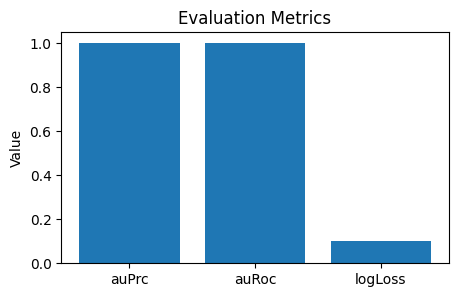

In [24]:
metrics = []
values = []
for i in evaluation_metrics.metadata.items():
    metrics.append(i[0])
    values.append(i[1])
plt.figure(figsize=(5, 3))
plt.bar(x=metrics, height=values)
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.show()

## Clean up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Dataset
- Model
- AutoML Training Job
- Cloud Storage Bucket


In [25]:
# If the bucket needs to be deleted too, please set "delete_bucket" to True
delete_bucket = False

# Delete the dataset using the Vertex dataset object
dataset.delete()

# Delete the model using the Vertex model object
model.delete()

# Delete the training job
training_job.delete()

# Delete the evaluation pipeline
job.delete()

# Delete the Cloud storage bucket
if delete_bucket:
    ! gsutil rm -r $BUCKET_URI

Deleting VideoDataset : projects/314481442207/locations/us-central1/datasets/1005225207159324672
VideoDataset deleted. . Resource name: projects/314481442207/locations/us-central1/datasets/1005225207159324672
Deleting VideoDataset resource: projects/314481442207/locations/us-central1/datasets/1005225207159324672
Delete VideoDataset backing LRO: projects/314481442207/locations/us-central1/operations/9055838110100750336
VideoDataset resource projects/314481442207/locations/us-central1/datasets/1005225207159324672 deleted.
Deleting Model : projects/314481442207/locations/us-central1/models/5412984803983097856
Model deleted. . Resource name: projects/314481442207/locations/us-central1/models/5412984803983097856
Deleting Model resource: projects/314481442207/locations/us-central1/models/5412984803983097856
Delete Model backing LRO: projects/314481442207/locations/us-central1/models/5412984803983097856/operations/1874426291793428480
Model resource projects/314481442207/locations/us-central1/